In [338]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict

In [386]:
def find(array, value):
    return np.argwhere(np.array(array)==value)[0,0]

In [400]:
paths = glob.glob('r.*')
last = sorted(glob.glob('r.*'), key=lambda x : x.lstrip('r.'))[-1] + '/'

runs = []
for file in glob.glob(last + '*.pyT'):
    runs.append(torch.load(file))
    
constraints = {}
#constraints['test_noise'] = True
#constraints['d'] = 10
#constraints['n'] = 1000
constraints['loss_type'] = 'linear_hinge'
#constraints['seed'] = 0

selected_runs = []
for irun, run in enumerate(runs):
    keep = True
    for k,v in constraints.items():
        if getattr(run['args'],k) != v:
            keep = False
            break
    if keep:
        selected_runs.append(run)
    
runs_grouped = defaultdict(list)
for run in selected_runs:
    args = run['args'].__dict__
    del(args['seed'])
    del(args['name'])
    args = str(args.values())
    runs_grouped[args].append(run)
    
print(len(runs),len(selected_runs), len(runs_grouped))
    
params = torch.load(last+'params.pkl')
params

312 156 32


{'noise': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
 'lr': [0.01],
 'n': [10, 100, 1000],
 'd': [10, 100, 1000],
 'seed': range(0, 5),
 'test_noise': [False],
 'loss_type': ['mse', 'linear_hinge'],
 'epsilon': [0.01]}

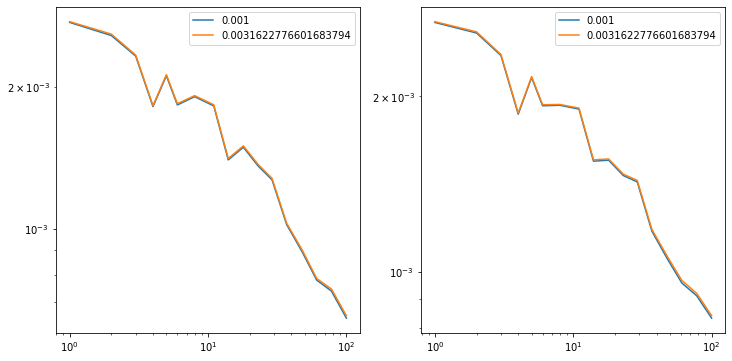

In [362]:
fig, axarr = plt.subplots(1,2, figsize=(12,6))

for group in runs_grouped.values():
    args = group[0]['args']
    widths = group[0]['widths']
    train_losses = np.mean(np.array([run['train_loss'] for run in group]), axis=0)
    test_losses =  np.mean(np.array([run['test_loss'] for run in group]), axis=0)
    axarr[0].plot(widths, train_losses,label=args.noise)
    axarr[1].plot(widths, test_losses ,label=args.noise)
for ax in axarr:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

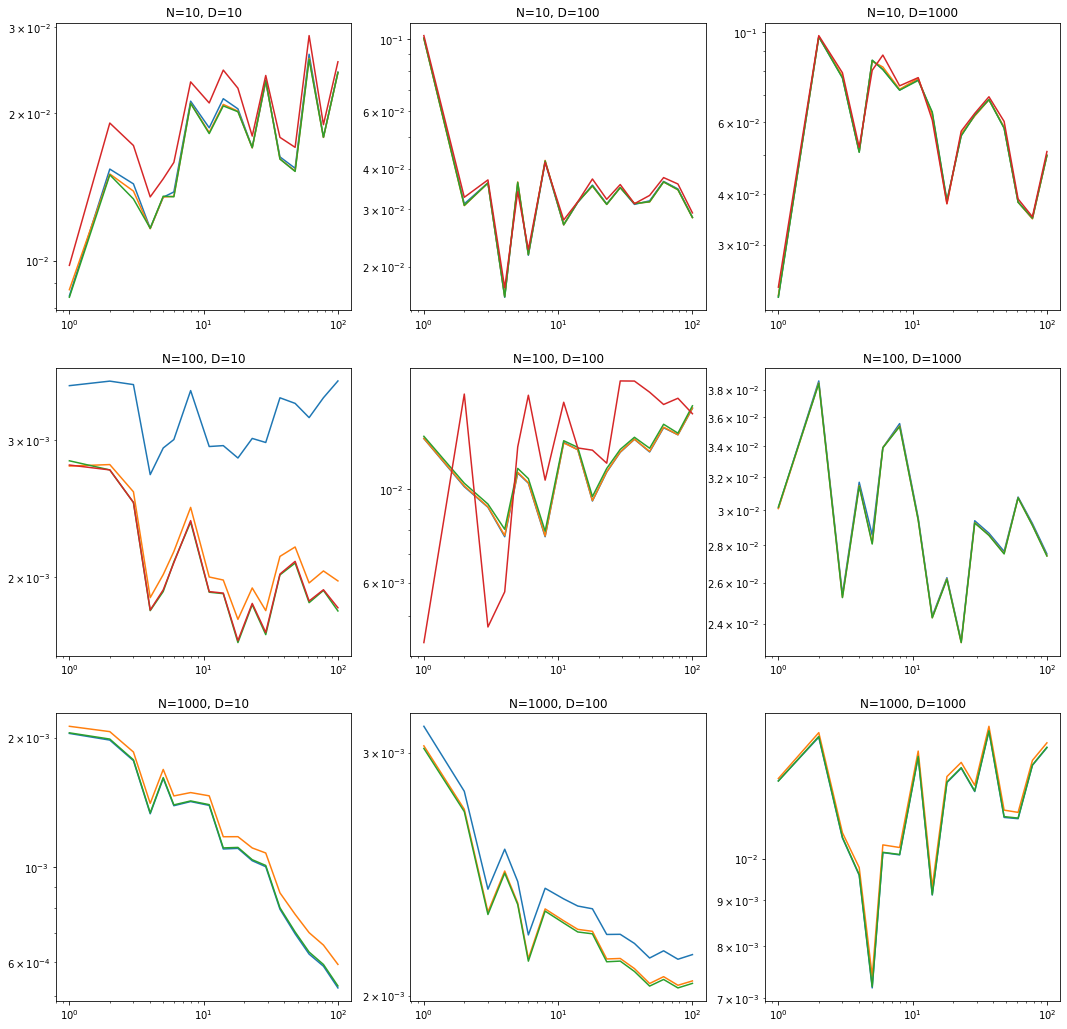

In [401]:
fig, axarr = plt.subplots(len(params['n']), len(params['d']), figsize=(18,18))

for group in runs_grouped.values():
    args = group[0]['args']
    n, d = args.n, args.d
    i, j = find(params['n'],n), find(params['d'],d)
    widths = group[0]['widths']
    train_losses = np.mean(np.array([run['train_loss'] for run in group]), axis=0)
    test_losses =  np.mean(np.array([run['test_loss'] for run in group]), axis=0)
    #axarr[i,j].plot(widths, train_losses,label=args.noise)
    axarr[i,j].plot(widths, test_losses ,label=args.noise)
    axarr[i,j].set_title('N=%d, D=%d'%(n,d))
axarr = axarr.flatten()
for ax in axarr:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.legend()

In [385]:
find(params['n'],10)

In [367]:
params['n']==100

False